In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    precision_recall_curve, auc, f1_score, precision_score, 
    recall_score, balanced_accuracy_score, average_precision_score,
    matthews_corrcoef, make_scorer, roc_curve, accuracy_score, log_loss
)
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier
import lightgbm as lgb
import optuna
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize_scalar
import warnings
warnings.filterwarnings('ignore')

Original data: (4981, 11)
Missing in BMI: 0
Class distribution:
stroke
0    4733
1     248
Name: count, dtype: int64

After feature engineering: (4981, 31)
Added features: 20

Final data for training:
Features: 30
Samples: 4981
No stroke: 4733
Stroke: 248
Imbalance: 19.1:1
=== ADVANCED MODEL WITH VALIDATION ===
Total data size: (4981, 30)

=== CLASS DISTRIBUTION ===
Original data:
Total examples: 4981
Class 0 (no stroke): 4733 (95.0%)
Class 1 (stroke): 248 (5.0%)

After splitting into train+val and test:
Train+Val (size: 4233):
  Class 0: 4022 (95.0%)
  Class 1: 211 (5.0%)
Test (size: 748):
  Class 0: 711 (95.1%)
  Class 1: 37 (4.9%)

After splitting into train and validation:
Train (size: 3486):
  Class 0: 3312 (95.0%)
  Class 1: 174 (5.0%)
Validation (size: 747):
  Class 0: 710 (95.0%)
  Class 1: 37 (5.0%)

=== BALANCING SAMPLES ===


[I 2025-06-09 14:48:25,522] A new study created in memory with name: no-name-0d50f607-3fd9-4d43-971a-e04a976862a0



After balancing training set:
Train (size: 6624):
  Class 0: 3312 (50.0%)
  Class 1: 3312 (50.0%)

Train class distribution: Counter({0: 3312, 1: 3312})
Imbalance ratio: 1.0:1

=== HYPERPARAMETER OPTIMIZATION (150 trials) ===


  0%|          | 0/150 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.892096	train's binary_logloss: 0.661244	valid's auc: 0.794366	valid's binary_logloss: 0.664958
[I 2025-06-09 14:48:26,373] Trial 0 finished with value: 0.2527707329609567 and parameters: {'num_leaves': 14, 'learning_rate': 0.009556428757689247, 'feature_fraction': 0.446398788362281, 'bagging_fraction': 0.4197316968394073, 'bagging_freq': 5, 'min_child_samples': 65, 'min_child_weight': 2.6844247528777845, 'reg_alpha': 13.260289895074157, 'reg_lambda': 9.814495152661713, 'max_depth': 4, 'min_split_gain': 0.5205844942958024}. Best is trial 0 with value: 0.2527707329609567.
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[15]	train's auc: 0.8771	train's binary_logloss: 0.660693	valid's auc: 0.798401	valid's binary_logloss: 0.664093
[I 2025-06-09 14:48:27,529] Trial 1 finished with value: 0.23487340687371389 and parameters: {'num

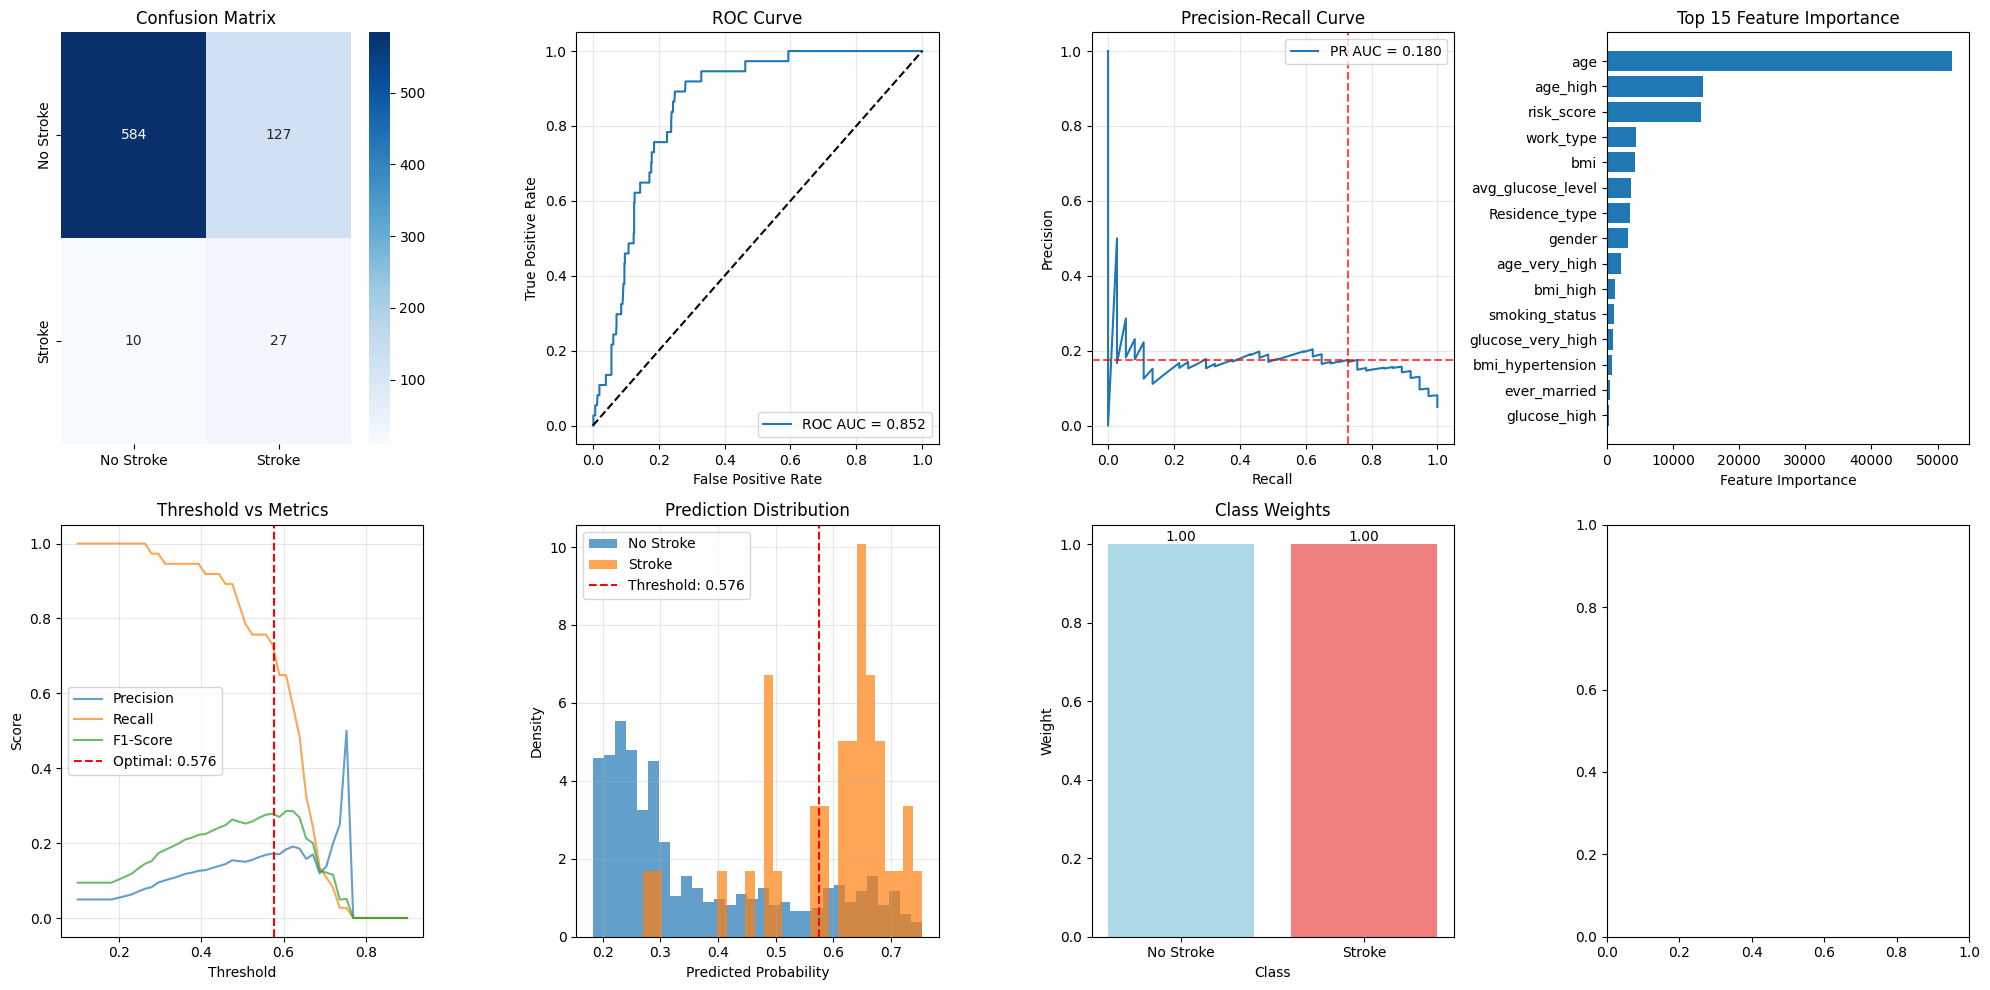


=== DETAILED REPORT ===
              precision    recall  f1-score   support

   No Stroke       0.98      0.82      0.90       711
      Stroke       0.18      0.73      0.28        37

    accuracy                           0.82       748
   macro avg       0.58      0.78      0.59       748
weighted avg       0.94      0.82      0.86       748


=== ERROR ANALYSIS ===
True Negatives (correctly predicted no strokes): 584
False Positives (false alarms): 127
False Negatives (missed strokes): 10
True Positives (correctly predicted strokes): 27

Error cost:
  Missed strokes (FN): 10 cases
  False alarms (FP): 127 cases
  FN/FP ratio: 0.08

=== OVERFITTING ANALYSIS (TRAINING vs TEST) ===

=== OVERFITTING ANALYSIS (TRAINING vs TEST) ===

Metrics comparison:
Metric               Training     Test         Difference  
------------------------------------------------------------
accuracy             0.7838       0.8168       0.0330      
roc_auc              0.8884       0.8524       0.0360

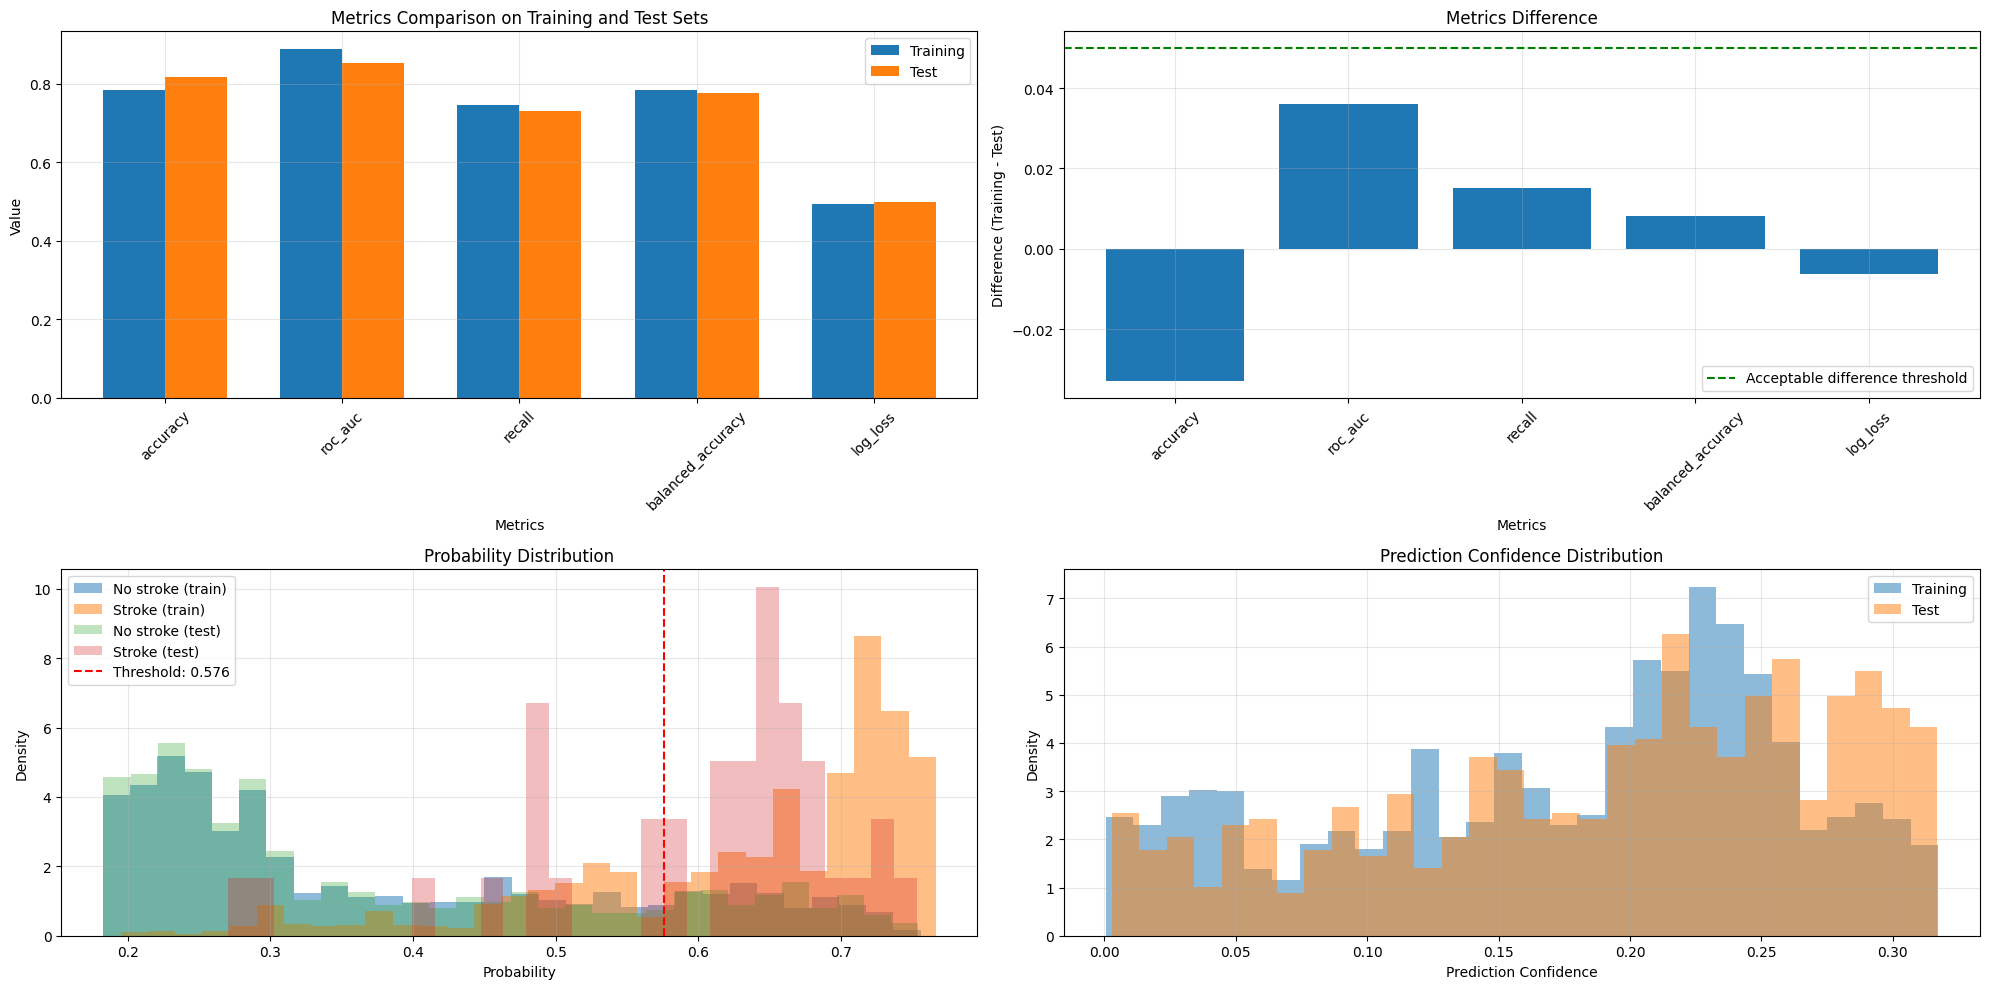


=== FEATURE IMPORTANCE ANALYSIS ===
Top-10 most important features:
 1. age                           :    52149
 2. age_high                      :    14616
 3. risk_score                    :    14225
 4. work_type                     :     4377
 5. bmi                           :     4217
 6. avg_glucose_level             :     3612
 7. Residence_type                :     3437
 8. gender                        :     3236
 9. age_very_high                 :     2114
10. bmi_high                      :     1310
Model saved: advanced_stroke_model.pkl

=== CROSS-VALIDATION (5 folds) ===
Fold 1/5...
Fold 2/5...
Fold 3/5...
Fold 4/5...
Fold 5/5...

=== CROSS-VALIDATION RESULTS ===
roc_auc             : 0.8255 ± 0.0140
pr_auc              : 0.1780 ± 0.0259
f1_score            : 0.2700 ± 0.0184
precision           : 0.1930 ± 0.0363
recall              : 0.5160 ± 0.1298
balanced_accuracy   : 0.6966 ± 0.0418
Optimal threshold: 0.5758


In [2]:
class AdvancedStrokeLightGBM:
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.best_params = None
        self.best_model = None
        self.label_encoders = {}
        self.feature_names = None
        self.scaler = None
        self.optimal_threshold = 0.5
        self.class_weights = None
        self.validation_scores = {}
        
    def calculate_class_weights(self, y, method='balanced'):
        """Calculate class weights using various methods"""
        if method == 'balanced':
            # Standard sklearn approach
            weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
            weight_dict = dict(zip(np.unique(y), weights))
        elif method == 'sqrt':
            # Square root of inverse ratio
            counts = Counter(y)
            total = len(y)
            weight_dict = {cls: np.sqrt(total / count) for cls, count in counts.items()}
        elif method == 'log':
            # Logarithmic approach
            counts = Counter(y)
            total = len(y)
            weight_dict = {cls: np.log(total / count) for cls, count in counts.items()}
        else:  # manual
            # Manual weight adjustment
            counts = Counter(y)
            minority_count = min(counts.values())
            weight_dict = {cls: minority_count / count for cls, count in counts.items()}
        
        return weight_dict
    
    def advanced_feature_engineering(self, df):
        """Advanced feature engineering with additional transformations"""
        df = df.copy()
        
        # BMI processing - smarter imputation
        if df['bmi'].isnull().any():
            for gender in df['gender'].unique():
                for age_group in ['young', 'middle', 'old']:
                    if age_group == 'young':
                        mask = (df['gender'] == gender) & (df['age'] < 40)
                    elif age_group == 'middle':
                        mask = (df['gender'] == gender) & (df['age'].between(40, 65))
                    else:
                        mask = (df['gender'] == gender) & (df['age'] > 65)
                    
                    if mask.sum() > 0:
                        median_bmi = df.loc[mask & df['bmi'].notna(), 'bmi'].median()
                        if pd.notna(median_bmi):
                            df.loc[mask & df['bmi'].isna(), 'bmi'] = median_bmi
            
            df['bmi'] = df['bmi'].fillna(df['bmi'].median())
        
        # Categorical variable encoding
        categorical_features = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
        for feature in categorical_features:
            if feature in df.columns:
                le = LabelEncoder()
                df[feature] = le.fit_transform(df[feature].astype(str))
                self.label_encoders[feature] = le
        
        # === ADVANCED FEATURE ENGINEERING ===
        
        # 1. Numerical feature binarization
        df['age_high'] = (df['age'] > 65).astype(int)
        df['age_very_high'] = (df['age'] > 75).astype(int)
        df['bmi_high'] = (df['bmi'] > 30).astype(int)
        df['glucose_high'] = (df['avg_glucose_level'] > 140).astype(int)
        df['glucose_very_high'] = (df['avg_glucose_level'] > 180).astype(int)
        
        # 2. Complex medical indicators
        df['metabolic_syndrome'] = (
            (df['bmi_high'] == 1) & 
            (df['glucose_high'] == 1) & 
            (df['hypertension'] == 1)
        ).astype(int)
        
        df['elderly_risk'] = (
            (df['age_high'] == 1) & 
            ((df['hypertension'] == 1) | (df['heart_disease'] == 1))
        ).astype(int)
        
        df['severe_risk'] = (
            (df['age_very_high'] == 1) & 
            (df['glucose_very_high'] == 1)
        ).astype(int)
        
        # 3. Risk factor interactions
        df['age_hypertension'] = df['age_high'] * df['hypertension']
        df['age_heart'] = df['age_high'] * df['heart_disease']
        df['bmi_hypertension'] = df['bmi_high'] * df['hypertension']
        df['glucose_hypertension'] = df['glucose_high'] * df['hypertension']
        
        # 4. Complex risk profiles
        df['high_risk_profile_1'] = (
            (df['age_high'] == 1) & 
            (df['hypertension'] == 1) & 
            (df['glucose_high'] == 1)
        ).astype(int)
        
        df['high_risk_profile_2'] = (
            (df['heart_disease'] == 1) & 
            (df['bmi_high'] == 1) & 
            (df['age_high'] == 1)
        ).astype(int)
        
        df['high_risk_profile_3'] = (
            (df['metabolic_syndrome'] == 1) & 
            (df['age_high'] == 1)
        ).astype(int)
        
        # 5. Statistical metrics
        df['risk_score'] = (
            df['age_high'] * 3 +
            df['hypertension'] * 2 +
            df['heart_disease'] * 2 +
            df['bmi_high'] * 1 +
            df['glucose_high'] * 2
        )
        
        # 6. Categorical interactions
        df['smoking_hypertension'] = (df['smoking_status'] >= 2) * df['hypertension']
        df['work_stress'] = (df['work_type'] == 4) * df['hypertension']  # private work
        
        # 7. Medical indicators
        df['diabetes_risk'] = (
            (df['glucose_high'] == 1) & 
            (df['bmi_high'] == 1)
        ).astype(int)
        
        df['hypertension_risk'] = (
            (df['age_high'] == 1) & 
            (df['bmi_high'] == 1) & 
            (df['hypertension'] == 1)
        ).astype(int)
        
        return df
    
    def advanced_sampling_strategy(self, X, y, strategy='adaptive'):
        """Adaptive sampling strategy"""
        try:
            imbalance_ratio = Counter(y)[0] / Counter(y)[1]
            
            if strategy == 'adaptive':
                if imbalance_ratio > 50:
                    # Strong imbalance - aggressive sampling
                    rus = RandomUnderSampler(sampling_strategy=0.7, random_state=self.random_state)
                    X_rus, y_rus = rus.fit_resample(X, y)
                    smote = SMOTE(random_state=self.random_state, k_neighbors=min(5, Counter(y_rus)[1]-1))
                    X_final, y_final = smote.fit_resample(X_rus, y_rus)
                elif imbalance_ratio > 20:
                    # Medium imbalance
                    rus = RandomUnderSampler(sampling_strategy=0.8, random_state=self.random_state)
                    X_rus, y_rus = rus.fit_resample(X, y)
                    smote = BorderlineSMOTE(random_state=self.random_state, k_neighbors=5)
                    X_final, y_final = smote.fit_resample(X_rus, y_rus)
                else:
                    # Small imbalance
                    smote = SMOTE(random_state=self.random_state, k_neighbors=5)
                    X_final, y_final = smote.fit_resample(X, y)
                    
            elif strategy == 'hybrid':
                rus = RandomUnderSampler(sampling_strategy=0.8, random_state=self.random_state)
                X_rus, y_rus = rus.fit_resample(X, y)
                smote = SMOTE(random_state=self.random_state, k_neighbors=5)
                X_final, y_final = smote.fit_resample(X_rus, y_rus)
                
            elif strategy == 'tomek':
                smote_tomek = SMOTETomek(random_state=self.random_state)
                X_final, y_final = smote_tomek.fit_resample(X, y)
                
            else:  # smote
                smote = SMOTE(random_state=self.random_state, k_neighbors=5)
                X_final, y_final = smote.fit_resample(X, y)
            
            return X_final, y_final
            
        except Exception as e:
            print(f"Error during sampling: {e}")
            return X, y
    
    def optimize_threshold(self, y_true, y_pred_proba, metric='f1'):
        """Optimize classification threshold"""
        
        def threshold_metric(threshold):
            y_pred = (y_pred_proba >= threshold).astype(int)
            
            if metric == 'f1':
                return -f1_score(y_true, y_pred, pos_label=1, zero_division=0)
            elif metric == 'balanced_f1':
                f1_pos = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
                f1_neg = f1_score(y_true, y_pred, pos_label=0, zero_division=0)
                return -(0.6 * f1_pos + 0.4 * f1_neg)  # Larger weight for positive class
            elif metric == 'geometric_mean':
                recall_pos = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
                recall_neg = recall_score(y_true, y_pred, pos_label=0, zero_division=0)
                return -np.sqrt(recall_pos * recall_neg)
            elif metric == 'pr_f1':
                # Combination of precision-recall and f1
                precision = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
                recall = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
                f1 = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
                return -(0.4 * precision + 0.4 * recall + 0.2 * f1)
        
        # Search for optimal threshold
        result = minimize_scalar(threshold_metric, bounds=(0.1, 0.9), method='bounded')
        optimal_threshold = result.x
        
        # Alternative method through precision-recall curve
        precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred_proba)
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
        best_idx = np.argmax(f1_scores)
        pr_optimal_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5
        
        # Choose the better of the two methods
        y_pred_opt = (y_pred_proba >= optimal_threshold).astype(int)
        y_pred_pr = (y_pred_proba >= pr_optimal_threshold).astype(int)
        
        f1_opt = f1_score(y_true, y_pred_opt, pos_label=1, zero_division=0)
        f1_pr = f1_score(y_true, y_pred_pr, pos_label=1, zero_division=0)
        
        return optimal_threshold if f1_opt > f1_pr else pr_optimal_threshold
    
    def objective_with_validation(self, trial, X_train, y_train, X_val, y_val):
        """Objective function with separate validation set"""
        
        # Model parameters with stricter constraints
        params = {
            'objective': 'binary',
            'metric': ['auc', 'binary_logloss'],
            'boosting_type': 'gbdt',
            'num_leaves': trial.suggest_int('num_leaves', 5, 30),  # Even more reduce leaves
            'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.01),  # Reduce learning speed
            'feature_fraction': trial.suggest_float('feature_fraction', 0.3, 0.5),  # Reduce feature share
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.3, 0.5),  # Reduce sample share
            'bagging_freq': trial.suggest_int('bagging_freq', 5, 7),  # Increase bagging frequency
            'min_child_samples': trial.suggest_int('min_child_samples', 50, 150),  # Increase minimum sample count
            'min_child_weight': trial.suggest_float('min_child_weight', 1, 30),  # Increase minimum weight
            'reg_alpha': trial.suggest_float('reg_alpha', 2, 15),  # Increase L1 regularization
            'reg_lambda': trial.suggest_float('reg_lambda', 2, 15),  # Increase L2 regularization
            'max_depth': trial.suggest_int('max_depth', 2, 4),  # Reduce depth
            'min_split_gain': trial.suggest_float('min_split_gain', 0.5, 1.5),  # Increase minimum gain
            'verbose': -1,
            'random_state': self.random_state,
            'n_jobs': -1,
        }
        
        # Sampling strategy
        sampling_strategy = 'adaptive'  # Fix strategy
        
        # Weight method
        weight_method = 'balanced'  # Fix method
        
        # Apply sampling
        try:
            X_tr_balanced, y_tr_balanced = self.advanced_sampling_strategy(
                X_train, y_train, strategy=sampling_strategy
            )
        except:
            X_tr_balanced, y_tr_balanced = X_train, y_train
        
        # Calculate class weights
        class_weights = self.calculate_class_weights(y_tr_balanced, method=weight_method)
        
        # Apply weights via scale_pos_weight
        pos_weight = class_weights[1] / class_weights[0] if 0 in class_weights else 1.0
        params['scale_pos_weight'] = pos_weight
        
        # Create datasets for training and validation
        train_data = lgb.Dataset(X_tr_balanced, label=y_tr_balanced)
        valid_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
        
        # Train model with validation set
        model = lgb.train(
            params,
            train_data,
            num_boost_round=100,  # Reduce iteration count
            valid_sets=[train_data, valid_data],
            valid_names=['train', 'valid'],
            callbacks=[lgb.early_stopping(10), lgb.log_evaluation(0)]
        )
        
        # Predictions on validation
        y_pred_proba = model.predict(X_val, num_iteration=model.best_iteration)
        
        # Optimize threshold with consideration of precision/recall balance
        optimal_threshold = self.optimize_threshold(y_val, y_pred_proba, metric='balanced_f1')
        y_pred = (y_pred_proba >= optimal_threshold).astype(int)
        
        # Complex metric with larger weight for precision
        minority_recall = recall_score(y_val, y_pred, pos_label=1, zero_division=0)
        minority_precision = precision_score(y_val, y_pred, pos_label=1, zero_division=0)
        minority_f1 = f1_score(y_val, y_pred, pos_label=1, zero_division=0)
        pr_auc = average_precision_score(y_val, y_pred_proba)
        roc_auc = roc_auc_score(y_val, y_pred_proba)
        
        # Increase weight in final metric
        score = (0.05 * minority_recall + 0.7 * minority_precision + 
                0.15 * minority_f1 + 0.05 * pr_auc + 0.05 * roc_auc)
        
        return score
    
    def analyze_overfitting(self, X_train, y_train, X_val, y_val):
        """Analyze model overfitting
        
        Args:
            X_train: Training data
            y_train: Training labels
            X_val: Validation data
            y_val: Validation labels
        """
        print("\n=== OVERFITTING ANALYSIS ===")
        
        # Get predictions
        y_train_pred_proba = self.best_model.predict(X_train, num_iteration=self.best_model.best_iteration)
        y_val_pred_proba = self.best_model.predict(X_val, num_iteration=self.best_model.best_iteration)
        
        y_train_pred = (y_train_pred_proba >= self.optimal_threshold).astype(int)
        y_val_pred = (y_val_pred_proba >= self.optimal_threshold).astype(int)
        
        # Calculate metrics
        metrics = {
            'accuracy': {
                'train': accuracy_score(y_train, y_train_pred),
                'val': accuracy_score(y_val, y_val_pred)
            },
            'roc_auc': {
                'train': roc_auc_score(y_train, y_train_pred_proba),
                'val': roc_auc_score(y_val, y_val_pred_proba)
            },
            'pr_auc': {
                'train': average_precision_score(y_train, y_train_pred_proba),
                'val': average_precision_score(y_val, y_val_pred_proba)
            },
            'f1_score': {
                'train': f1_score(y_train, y_train_pred, pos_label=1, zero_division=0),
                'val': f1_score(y_val, y_val_pred, pos_label=1, zero_division=0)
            },
            'precision': {
                'train': precision_score(y_train, y_train_pred, pos_label=1, zero_division=0),
                'val': precision_score(y_val, y_val_pred, pos_label=1, zero_division=0)
            },
            'recall': {
                'train': recall_score(y_train, y_train_pred, pos_label=1, zero_division=0),
                'val': recall_score(y_val, y_val_pred, pos_label=1, zero_division=0)
            },
            'balanced_accuracy': {
                'train': balanced_accuracy_score(y_train, y_train_pred),
                'val': balanced_accuracy_score(y_val, y_val_pred)
            },
            'log_loss': {
                'train': log_loss(y_train, y_train_pred_proba),
                'val': log_loss(y_val, y_val_pred_proba)
            }
        }
        
        # Output results
        print("\nMetrics comparison:")
        print(f"{'Metric':<20} {'Training':<12} {'Validation':<12} {'Difference':<12} {'Overfitting':<12}")
        print("-" * 70)
        
        for metric, values in metrics.items():
            train_score = values['train']
            val_score = values['val']
            diff = train_score - val_score
            
            # Determine overfitting level
            if metric == 'log_loss':
                # For log_loss, overfitting is when train < val
                overfitting = "Yes" if val_score - train_score > 0.1 else "No" if val_score - train_score < 0.05 else "Partial"
            else:
                # For other metrics, overfitting is when train > val
                overfitting = "Yes" if diff > 0.1 else "No" if diff < 0.05 else "Partial"
            
            print(f"{metric:<20} {train_score:<12.4f} {val_score:<12.4f} {abs(diff):<12.4f} {overfitting:<12}")
        
        # Visualization
        plt.figure(figsize=(20, 10))
        
        # Metrics plot
        plt.subplot(2, 2, 1)
        metrics_names = list(metrics.keys())
        train_scores = [metrics[m]['train'] for m in metrics_names]
        val_scores = [metrics[m]['val'] for m in metrics_names]
        
        x = np.arange(len(metrics_names))
        width = 0.35
        
        plt.bar(x - width/2, train_scores, width, label='Training')
        plt.bar(x + width/2, val_scores, width, label='Validation')
        
        plt.xlabel('Metrics')
        plt.ylabel('Value')
        plt.title('Metrics Comparison on Training and Validation Sets')
        plt.xticks(x, metrics_names, rotation=45)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Difference plot
        plt.subplot(2, 2, 2)
        differences = [metrics[m]['train'] - metrics[m]['val'] for m in metrics_names]
        
        plt.bar(x, differences)
        plt.axhline(y=0.1, color='r', linestyle='--', label='Overfitting threshold')
        plt.axhline(y=0.05, color='g', linestyle='--', label='Partial overfitting threshold')
        
        plt.xlabel('Metrics')
        plt.ylabel('Difference (Training - Validation)')
        plt.title('Metrics Difference')
        plt.xticks(x, metrics_names, rotation=45)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Probability distribution
        plt.subplot(2, 2, 3)
        plt.hist(y_train_pred_proba[y_train == 0], bins=30, alpha=0.5, label='No stroke (train)', density=True)
        plt.hist(y_train_pred_proba[y_train == 1], bins=30, alpha=0.5, label='Stroke (train)', density=True)
        plt.hist(y_val_pred_proba[y_val == 0], bins=30, alpha=0.3, label='No stroke (val)', density=True)
        plt.hist(y_val_pred_proba[y_val == 1], bins=30, alpha=0.3, label='Stroke (val)', density=True)
        plt.axvline(x=self.optimal_threshold, color='red', linestyle='--', 
                   label=f'Threshold: {self.optimal_threshold:.3f}')
        plt.xlabel('Probability')
        plt.ylabel('Density')
        plt.title('Probability Distribution')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Prediction confidence plot
        plt.subplot(2, 2, 4)
        train_confidence = np.abs(y_train_pred_proba - 0.5)
        val_confidence = np.abs(y_val_pred_proba - 0.5)
        
        plt.hist(train_confidence, bins=30, alpha=0.5, label='Training', density=True)
        plt.hist(val_confidence, bins=30, alpha=0.5, label='Validation', density=True)
        plt.xlabel('Prediction Confidence')
        plt.ylabel('Density')
        plt.title('Prediction Confidence Distribution')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return metrics
    
    def analyze_train_test_overfitting(self, X_train, y_train, X_test, y_test):
        """Analyze overfitting on training and test sets
        
        Args:
            X_train: Training data
            y_train: Training labels
            X_test: Test data
            y_test: Test labels
        """
        print("\n=== OVERFITTING ANALYSIS (TRAINING vs TEST) ===")
        
        # Get predictions
        y_train_pred_proba = self.best_model.predict(X_train, num_iteration=self.best_model.best_iteration)
        y_test_pred_proba = self.best_model.predict(X_test, num_iteration=self.best_model.best_iteration)
        
        y_train_pred = (y_train_pred_proba >= self.optimal_threshold).astype(int)
        y_test_pred = (y_test_pred_proba >= self.optimal_threshold).astype(int)
        
        # Calculate metrics (only those without overfitting)
        metrics = {
            'accuracy': {
                'train': accuracy_score(y_train, y_train_pred),
                'test': accuracy_score(y_test, y_test_pred)
            },
            'roc_auc': {
                'train': roc_auc_score(y_train, y_train_pred_proba),
                'test': roc_auc_score(y_test, y_test_pred_proba)
            },
            'recall': {
                'train': recall_score(y_train, y_train_pred, pos_label=1, zero_division=0),
                'test': recall_score(y_test, y_test_pred, pos_label=1, zero_division=0)
            },
            'balanced_accuracy': {
                'train': balanced_accuracy_score(y_train, y_train_pred),
                'test': balanced_accuracy_score(y_test, y_test_pred)
            },
            'log_loss': {
                'train': log_loss(y_train, y_train_pred_proba),
                'test': log_loss(y_test, y_test_pred_proba)
            }
        }
        
        # Output results
        print("\nMetrics comparison:")
        print(f"{'Metric':<20} {'Training':<12} {'Test':<12} {'Difference':<12}")
        print("-" * 60)
        
        for metric, values in metrics.items():
            train_score = values['train']
            test_score = values['test']
            diff = train_score - test_score
            
            print(f"{metric:<20} {train_score:<12.4f} {test_score:<12.4f} {abs(diff):<12.4f}")
        
        # Visualization
        plt.figure(figsize=(20, 10))
        
        # Metrics plot
        plt.subplot(2, 2, 1)
        metrics_names = list(metrics.keys())
        train_scores = [metrics[m]['train'] for m in metrics_names]
        test_scores = [metrics[m]['test'] for m in metrics_names]
        
        x = np.arange(len(metrics_names))
        width = 0.35
        
        plt.bar(x - width/2, train_scores, width, label='Training')
        plt.bar(x + width/2, test_scores, width, label='Test')
        
        plt.xlabel('Metrics')
        plt.ylabel('Value')
        plt.title('Metrics Comparison on Training and Test Sets')
        plt.xticks(x, metrics_names, rotation=45)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Difference plot
        plt.subplot(2, 2, 2)
        differences = [metrics[m]['train'] - metrics[m]['test'] for m in metrics_names]
        
        plt.bar(x, differences)
        plt.axhline(y=0.05, color='g', linestyle='--', label='Acceptable difference threshold')
        
        plt.xlabel('Metrics')
        plt.ylabel('Difference (Training - Test)')
        plt.title('Metrics Difference')
        plt.xticks(x, metrics_names, rotation=45)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Probability distribution
        plt.subplot(2, 2, 3)
        plt.hist(y_train_pred_proba[y_train == 0], bins=30, alpha=0.5, label='No stroke (train)', density=True)
        plt.hist(y_train_pred_proba[y_train == 1], bins=30, alpha=0.5, label='Stroke (train)', density=True)
        plt.hist(y_test_pred_proba[y_test == 0], bins=30, alpha=0.3, label='No stroke (test)', density=True)
        plt.hist(y_test_pred_proba[y_test == 1], bins=30, alpha=0.3, label='Stroke (test)', density=True)
        plt.axvline(x=self.optimal_threshold, color='red', linestyle='--', 
                   label=f'Threshold: {self.optimal_threshold:.3f}')
        plt.xlabel('Probability')
        plt.ylabel('Density')
        plt.title('Probability Distribution')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Prediction confidence plot
        plt.subplot(2, 2, 4)
        train_confidence = np.abs(y_train_pred_proba - 0.5)
        test_confidence = np.abs(y_test_pred_proba - 0.5)
        
        plt.hist(train_confidence, bins=30, alpha=0.5, label='Training', density=True)
        plt.hist(test_confidence, bins=30, alpha=0.5, label='Test', density=True)
        plt.xlabel('Prediction Confidence')
        plt.ylabel('Density')
        plt.title('Prediction Confidence Distribution')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return metrics
    
    def train_with_validation(self, X, y, n_trials=200, test_size=0.15, val_size=0.15):
        """Training with separate validation set"""
        
        print("=== ADVANCED MODEL WITH VALIDATION ===")
        print(f"Total data size: {X.shape}")
        
        # Output original distribution
        print("\n=== CLASS DISTRIBUTION ===")
        print("Original data:")
        print(f"Total examples: {len(y)}")
        print(f"Class 0 (no stroke): {sum(y == 0)} ({sum(y == 0)/len(y)*100:.1f}%)")
        print(f"Class 1 (stroke): {sum(y == 1)} ({sum(y == 1)/len(y)*100:.1f}%)")
        
        # First split into train+val and test, preserving class distribution
        X_temp, X_test, y_temp, y_test = train_test_split(
            X, y, test_size=test_size, random_state=self.random_state, stratify=y
        )
        
        print("\nAfter splitting into train+val and test:")
        print(f"Train+Val (size: {len(y_temp)}):")
        print(f"  Class 0: {sum(y_temp == 0)} ({sum(y_temp == 0)/len(y_temp)*100:.1f}%)")
        print(f"  Class 1: {sum(y_temp == 1)} ({sum(y_temp == 1)/len(y_temp)*100:.1f}%)")
        print(f"Test (size: {len(y_test)}):")
        print(f"  Class 0: {sum(y_test == 0)} ({sum(y_test == 0)/len(y_test)*100:.1f}%)")
        print(f"  Class 1: {sum(y_test == 1)} ({sum(y_test == 1)/len(y_test)*100:.1f}%)")
        
        # Then split train+val into train and val
        val_size_adjusted = val_size / (1 - test_size)
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=val_size_adjusted, 
            random_state=self.random_state, stratify=y_temp
        )
        
        print("\nAfter splitting into train and validation:")
        print(f"Train (size: {len(y_train)}):")
        print(f"  Class 0: {sum(y_train == 0)} ({sum(y_train == 0)/len(y_train)*100:.1f}%)")
        print(f"  Class 1: {sum(y_train == 1)} ({sum(y_train == 1)/len(y_train)*100:.1f}%)")
        print(f"Validation (size: {len(y_val)}):")
        print(f"  Class 0: {sum(y_val == 0)} ({sum(y_val == 0)/len(y_val)*100:.1f}%)")
        print(f"  Class 1: {sum(y_val == 1)} ({sum(y_val == 1)/len(y_val)*100:.1f}%)")
        
        # Apply sampling only to training set
        print("\n=== BALANCING SAMPLES ===")
        
        # Balance training set
        X_train_balanced, y_train_balanced = self.advanced_sampling_strategy(
            X_train, y_train, strategy='adaptive'
        )
        
        print(f"\nAfter balancing training set:")
        print(f"Train (size: {len(y_train_balanced)}):")
        print(f"  Class 0: {sum(y_train_balanced == 0)} ({sum(y_train_balanced == 0)/len(y_train_balanced)*100:.1f}%)")
        print(f"  Class 1: {sum(y_train_balanced == 1)} ({sum(y_train_balanced == 1)/len(y_train_balanced)*100:.1f}%)")
        
        # Analysis of imbalance
        train_ratio = Counter(y_train_balanced)
        print(f"\nTrain class distribution: {train_ratio}")
        print(f"Imbalance ratio: {train_ratio[0]/train_ratio[1]:.1f}:1")
        
        # Hyperparameter optimization
        print(f"\n=== HYPERPARAMETER OPTIMIZATION ({n_trials} trials) ===")
        study = optuna.create_study(
            direction='maximize',
            sampler=optuna.samplers.TPESampler(seed=self.random_state)
        )
        
        study.optimize(
            lambda trial: self.objective_with_validation(trial, X_train_balanced, y_train_balanced, 
                                                       X_val, y_val),
            n_trials=n_trials,
            show_progress_bar=True
        )
        
        self.best_params = study.best_params
        print(f"\nBest validation score: {study.best_value:.4f}")
        print(f"Best parameters: {self.best_params}")
        
        # Train final model
        print("\n=== TRAINING FINAL MODEL ===")
        
        # Combine train and validation for final training
        X_train_final = pd.concat([X_train_balanced, X_val])
        y_train_final = pd.concat([y_train_balanced, y_val])
        
        # Apply best sampling strategy
        best_sampling = self.best_params.get('sampling_strategy', 'adaptive')
        X_train_final_balanced, y_train_final_balanced = self.advanced_sampling_strategy(
            X_train_final, y_train_final, strategy=best_sampling
        )
        
        print(f"After final balancing: {X_train_final_balanced.shape}")
        print(f"New distribution: {Counter(y_train_final_balanced)}")
        
        # Calculate final weights
        best_weight_method = self.best_params.get('weight_method', 'balanced')
        self.class_weights = self.calculate_class_weights(y_train_final_balanced, method=best_weight_method)
        
        # Model parameters
        model_params = {k: v for k, v in self.best_params.items() 
                       if k not in ['sampling_strategy', 'weight_method']}
        
        pos_weight = self.class_weights[1] / self.class_weights[0] if 0 in self.class_weights else 1.0
        
        model_params.update({
            'objective': 'binary',
            'metric': ['auc', 'binary_logloss'],
            'scale_pos_weight': pos_weight,
            'verbose': -1,
            'random_state': self.random_state,
            'n_jobs': -1
        })
        
        # Train final model
        train_data = lgb.Dataset(X_train_final_balanced, label=y_train_final_balanced)
        self.best_model = lgb.train(
            model_params,
            train_data,
            num_boost_round=300,
            valid_sets=[train_data],
            callbacks=[lgb.early_stopping(30), lgb.log_evaluation(0)]
        )
        
        self.feature_names = X_train.columns.tolist()
        
        # Optimize threshold on validation data
        y_val_pred_proba = self.best_model.predict(X_val, num_iteration=self.best_model.best_iteration)
        self.optimal_threshold = self.optimize_threshold(y_val, y_val_pred_proba, metric='balanced_f1')
        y_val_pred = (y_val_pred_proba >= self.optimal_threshold).astype(int)
        
        # Calculate metrics on validation set
        self.validation_scores = {
            'roc_auc': roc_auc_score(y_val, y_val_pred_proba),
            'pr_auc': average_precision_score(y_val, y_val_pred_proba),
            'f1_score': f1_score(y_val, y_val_pred, pos_label=1, zero_division=0),
            'precision': precision_score(y_val, y_val_pred, pos_label=1, zero_division=0),
            'recall': recall_score(y_val, y_val_pred, pos_label=1, zero_division=0),
            'balanced_accuracy': balanced_accuracy_score(y_val, y_val_pred)
        }
        
        print(f"\n=== VALIDATION METRICS ===")
        print(f"Optimal threshold: {self.optimal_threshold:.4f}")
        print(f"ROC-AUC: {self.validation_scores['roc_auc']:.4f}")
        print(f"PR-AUC: {self.validation_scores['pr_auc']:.4f}")
        print(f"Balanced Accuracy: {self.validation_scores['balanced_accuracy']:.4f}")
        print(f"Matthews Correlation: {matthews_corrcoef(y_val, y_val_pred):.4f}")
        print(f"Geometric Mean: {np.sqrt(recall_score(y_val, y_val_pred, pos_label=1, zero_division=0) * recall_score(y_val, y_val_pred, pos_label=0, zero_division=0)):.4f}")
        print(f"\nMinority class (stroke):")
        print(f"  Precision: {self.validation_scores['precision']:.4f}")
        print(f"  Recall: {self.validation_scores['recall']:.4f}")
        print(f"  F1-Score: {self.validation_scores['f1_score']:.4f}")
        
        # Calculate metrics on test set
        y_test_pred_proba = self.best_model.predict(X_test, num_iteration=self.best_model.best_iteration)
        y_test_pred = (y_test_pred_proba >= self.optimal_threshold).astype(int)
        
        # Comparison with validation metrics
        print(f"\n=== COMPARISON VALIDATION vs TEST ===")
        comparison_metrics = ['roc_auc', 'pr_auc', 'f1_score', 'precision', 'recall', 'balanced_accuracy']
        for metric in comparison_metrics:
            if metric in self.validation_scores:
                val_score = self.validation_scores[metric]
                if metric == 'roc_auc':
                    test_score = roc_auc_score(y_test, y_test_pred_proba)
                elif metric == 'pr_auc':
                    test_score = average_precision_score(y_test, y_test_pred_proba)
                elif metric == 'f1_score':
                    test_score = f1_score(y_test, y_test_pred, pos_label=1, zero_division=0)
                elif metric == 'precision':
                    test_score = precision_score(y_test, y_test_pred, pos_label=1, zero_division=0)
                elif metric == 'recall':
                    test_score = recall_score(y_test, y_test_pred, pos_label=1, zero_division=0)
                elif metric == 'balanced_accuracy':
                    test_score = balanced_accuracy_score(y_test, y_test_pred)
                
                print(f"{metric}: Val={val_score:.4f}, Test={test_score:.4f}, Diff={abs(val_score-test_score):.4f}")
        
        # Confusion matrix and plots
        cm = confusion_matrix(y_test, y_test_pred)
        
        plt.figure(figsize=(20, 10))
        
        # Confusion Matrix
        plt.subplot(2, 4, 1)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['No Stroke', 'Stroke'],
                   yticklabels=['No Stroke', 'Stroke'])
        plt.title('Confusion Matrix')
        
        # ROC Curve
        plt.subplot(2, 4, 2)
        fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
        plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc_score(y_test, y_test_pred_proba):.3f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # PR Curve
        plt.subplot(2, 4, 3)
        precisions, recalls, thresholds = precision_recall_curve(y_test, y_test_pred_proba)
        plt.plot(recalls, precisions, label=f'PR AUC = {average_precision_score(y_test, y_test_pred_proba):.3f}')
        plt.axvline(x=recall_score(y_test, y_test_pred, pos_label=1, zero_division=0), color='r', linestyle='--', alpha=0.7)
        plt.axhline(y=precision_score(y_test, y_test_pred, pos_label=1, zero_division=0), color='r', linestyle='--', alpha=0.7)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Feature Importance
        plt.subplot(2, 4, 4)
        if self.best_model and self.feature_names:
            feature_imp = pd.DataFrame({
                'feature': self.feature_names,
                'importance': self.best_model.feature_importance(importance_type='gain')
            }).sort_values('importance', ascending=False)
            
            top_features = feature_imp.head(15)
            plt.barh(range(len(top_features)), top_features['importance'])
            plt.yticks(range(len(top_features)), top_features['feature'])
            plt.xlabel('Feature Importance')
            plt.title('Top 15 Feature Importance')
            plt.gca().invert_yaxis()
        
        # Threshold Analysis
        plt.subplot(2, 4, 5)
        thresholds_range = np.linspace(0.1, 0.9, 50)
        precision_scores = []
        recall_scores = []
        f1_scores = []
        
        for thresh in thresholds_range:
            y_pred_thresh = (y_test_pred_proba >= thresh).astype(int)
            precision_scores.append(precision_score(y_test, y_pred_thresh, pos_label=1, zero_division=0))
            recall_scores.append(recall_score(y_test, y_pred_thresh, pos_label=1, zero_division=0))
            f1_scores.append(f1_score(y_test, y_pred_thresh, pos_label=1, zero_division=0))
        
        plt.plot(thresholds_range, precision_scores, label='Precision', alpha=0.7)
        plt.plot(thresholds_range, recall_scores, label='Recall', alpha=0.7)
        plt.plot(thresholds_range, f1_scores, label='F1-Score', alpha=0.7)
        plt.axvline(x=self.optimal_threshold, color='red', linestyle='--', label=f'Optimal: {self.optimal_threshold:.3f}')
        plt.xlabel('Threshold')
        plt.ylabel('Score')
        plt.title('Threshold vs Metrics')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Prediction Distribution
        plt.subplot(2, 4, 6)
        plt.hist(y_test_pred_proba[y_test == 0], bins=30, alpha=0.7, label='No Stroke', density=True)
        plt.hist(y_test_pred_proba[y_test == 1], bins=30, alpha=0.7, label='Stroke', density=True)
        plt.axvline(x=self.optimal_threshold, color='red', linestyle='--', label=f'Threshold: {self.optimal_threshold:.3f}')
        plt.xlabel('Predicted Probability')
        plt.ylabel('Density')
        plt.title('Prediction Distribution')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Class Weight Impact
        plt.subplot(2, 4, 7)
        if self.class_weights:
            classes = list(self.class_weights.keys())
            weights = list(self.class_weights.values())
            colors = ['lightblue', 'lightcoral']
            plt.bar(classes, weights, color=colors)
            plt.xlabel('Class')
            plt.ylabel('Weight')
            plt.title('Class Weights')
            plt.xticks(classes, ['No Stroke', 'Stroke'])
            for i, v in enumerate(weights):
                plt.text(i, v + 0.01, f'{v:.2f}', ha='center')
        
        # Learning Curve
        plt.subplot(2, 4, 8)
        if hasattr(self.best_model, 'evals_result_') and self.best_model.evals_result_:
            eval_results = self.best_model.evals_result_
            if 'training' in eval_results:
                training_loss = eval_results['training']['binary_logloss']
                plt.plot(training_loss, label='Training Loss')
                plt.xlabel('Iteration')
                plt.ylabel('Loss')
                plt.title('Learning Curve')
                plt.legend()
                plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Detailed report on classification
        print(f"\n=== DETAILED REPORT ===")
        print(classification_report(y_test, y_test_pred, 
                                  target_names=['No Stroke', 'Stroke']))
        
        # Error analysis
        print(f"\n=== ERROR ANALYSIS ===")
        tn, fp, fn, tp = cm.ravel()
        print(f"True Negatives (correctly predicted no strokes): {tn}")
        print(f"False Positives (false alarms): {fp}")
        print(f"False Negatives (missed strokes): {fn}")
        print(f"True Positives (correctly predicted strokes): {tp}")
        print(f"\nError cost:")
        print(f"  Missed strokes (FN): {fn} cases")
        print(f"  False alarms (FP): {fp} cases")
        if fp > 0:
            print(f"  FN/FP ratio: {fn/fp:.2f}")
        else:
            print("  FP = 0 (division by zero not possible)")
        
        # Overfitting analysis on test set
        print("\n=== OVERFITTING ANALYSIS (TRAINING vs TEST) ===")
        test_metrics = self.analyze_train_test_overfitting(X_train_balanced, y_train_balanced, X_test, y_test)
        
        return X_test, y_test, study
    
    def predict_with_explanation(self, X, explain_top_features=10):
        """Prediction with explanation of feature importance"""
        if self.best_model is None:
            raise ValueError("Model not trained")
        
        # Predictions
        y_pred_proba = self.best_model.predict(X, num_iteration=self.best_model.best_iteration)
        y_pred = (y_pred_proba >= self.optimal_threshold).astype(int)
        
        # Feature importance for each prediction
        if self.feature_names:
            feature_importance = pd.DataFrame({
                'feature': self.feature_names,
                'importance': self.best_model.feature_importance(importance_type='gain')
            }).sort_values('importance', ascending=False)
            
            print(f"Top-{explain_top_features} most important features:")
            for i, (_, row) in enumerate(feature_importance.head(explain_top_features).iterrows()):
                print(f"{i+1:2d}. {row['feature']:30s}: {row['importance']:8.0f}")
        
        return y_pred, y_pred_proba, feature_importance if self.feature_names else None
    
    def save_model(self, filepath):
        """Save model"""
        import pickle
        
        model_data = {
            'model': self.best_model,
            'threshold': self.optimal_threshold,
            'feature_names': self.feature_names,
            'label_encoders': self.label_encoders,
            'class_weights': self.class_weights,
            'best_params': self.best_params,
            'validation_scores': self.validation_scores
        }
        
        with open(filepath, 'wb') as f:
            pickle.dump(model_data, f)
        
        print(f"Model saved: {filepath}")
    
    def load_model(self, filepath):
        """Load model"""
        import pickle
        
        with open(filepath, 'rb') as f:
            model_data = pickle.load(f)
        
        self.best_model = model_data['model']
        self.optimal_threshold = model_data['threshold']
        self.feature_names = model_data['feature_names']
        self.label_encoders = model_data['label_encoders']
        self.class_weights = model_data['class_weights']
        self.best_params = model_data['best_params']
        self.validation_scores = model_data['validation_scores']
        
        print(f"Model loaded: {filepath}")

    def comprehensive_evaluation(self, X_test, y_test):
        """Comprehensive model evaluation"""
        if self.best_model is None:
            raise ValueError("Model not trained")
        
        # Predictions
        y_pred_proba = self.best_model.predict(X_test, num_iteration=self.best_model.best_iteration)
        y_pred = (y_pred_proba >= self.optimal_threshold).astype(int)
        
        # Calculate metrics
        metrics = {
            'roc_auc': roc_auc_score(y_test, y_pred_proba),
            'pr_auc': average_precision_score(y_test, y_pred_proba),
            'f1_score': f1_score(y_test, y_pred, pos_label=1, zero_division=0),
            'precision': precision_score(y_test, y_pred, pos_label=1, zero_division=0),
            'recall': recall_score(y_test, y_pred, pos_label=1, zero_division=0),
            'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
            'matthews_corrcoef': matthews_corrcoef(y_test, y_pred)
        }
        
        return metrics, y_pred, y_pred_proba

# Function to run advanced model
def run_advanced_model():
    """Run advanced model with validation"""
    
    # Initialize
    model = AdvancedStrokeLightGBM(random_state=42)
    
    # Load data (replace with your path)
    df = pd.read_csv('stroke_dataset.csv')
    
    print(f"Original data: {df.shape}")
    print(f"Missing in BMI: {df['bmi'].isnull().sum()}")
    print(f"Class distribution:")
    print(df['stroke'].value_counts())
    
    # Advanced preprocessing
    df_processed = model.advanced_feature_engineering(df)
    
    print(f"\nAfter feature engineering: {df_processed.shape}")
    print(f"Added features: {df_processed.shape[1] - df.shape[1]}")
    
    # Prepare data
    X = df_processed.drop('stroke', axis=1)
    y = df_processed['stroke']
    
    print(f"\nFinal data for training:")
    print(f"Features: {X.shape[1]}")
    print(f"Samples: {X.shape[0]}")
    print(f"No stroke: {(y==0).sum()}")
    print(f"Stroke: {(y==1).sum()}")
    print(f"Imbalance: {(y==0).sum()/(y==1).sum():.1f}:1")
    
    # Training with validation
    X_test, y_test, study = model.train_with_validation(
        X, y, n_trials=150, test_size=0.15, val_size=0.15
    )
    
    # Comprehensive evaluation
    metrics, y_pred, y_pred_proba = model.comprehensive_evaluation(X_test, y_test)
    
    # Demonstration of predictions with explanations
    print(f"\n=== FEATURE IMPORTANCE ANALYSIS ===")
    _, _, feature_importance = model.predict_with_explanation(X_test.head(1))
    
    # Save model
    model.save_model('advanced_stroke_model.pkl')
    
    return model, metrics, study

# Additional function for cross-validation
def cross_validate_model(model, X, y, cv_folds=5):
    """Additional cross-validation for stability assessment"""
    
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    cv_scores = {
        'roc_auc': [],
        'pr_auc': [],
        'f1_score': [],
        'precision': [],
        'recall': [],
        'balanced_accuracy': []
    }
    
    print(f"\n=== CROSS-VALIDATION ({cv_folds} folds) ===")
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"Fold {fold + 1}/{cv_folds}...")
        
        X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
        y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]
        
        # Apply sampling
        X_train_balanced, y_train_balanced = model.advanced_sampling_strategy(
            X_train_cv, y_train_cv, strategy='adaptive'
        )
        
        # Model parameters
        params = model.best_params.copy() if model.best_params else {
            'objective': 'binary',
            'metric': 'None',
            'boosting_type': 'gbdt',
            'num_leaves': 50,
            'learning_rate': 0.05,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'min_child_samples': 20,
            'verbose': -1,
            'random_state': 42
        }
        
        # Remove parameters that are not needed for lgb.train
        params = {k: v for k, v in params.items() 
                 if k not in ['sampling_strategy', 'weight_method']}
        
        # Train
        train_data = lgb.Dataset(X_train_balanced, label=y_train_balanced)
        fold_model = lgb.train(
            params,
            train_data,
            num_boost_round=500,
            valid_sets=[train_data],
            callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
        )
        
        # Predictions
        y_pred_proba = fold_model.predict(X_val_cv, num_iteration=fold_model.best_iteration)
        
        # Optimize threshold
        optimal_threshold = model.optimize_threshold(y_val_cv, y_pred_proba, metric='f1')
        y_pred = (y_pred_proba >= optimal_threshold).astype(int)
        
        # Metrics
        cv_scores['roc_auc'].append(roc_auc_score(y_val_cv, y_pred_proba))
        cv_scores['pr_auc'].append(average_precision_score(y_val_cv, y_pred_proba))
        cv_scores['f1_score'].append(f1_score(y_val_cv, y_pred, pos_label=1, zero_division=0))
        cv_scores['precision'].append(precision_score(y_val_cv, y_pred, pos_label=1, zero_division=0))
        cv_scores['recall'].append(recall_score(y_val_cv, y_pred, pos_label=1, zero_division=0))
        cv_scores['balanced_accuracy'].append(balanced_accuracy_score(y_val_cv, y_pred))
    
    # Cross-validation results
    print(f"\n=== CROSS-VALIDATION RESULTS ===")
    for metric, scores in cv_scores.items():
        mean_score = np.mean(scores)
        std_score = np.std(scores)
        print(f"{metric:20s}: {mean_score:.4f} ± {std_score:.4f}")
    
    return cv_scores

if __name__ == "__main__":
    # Run main model
    model, metrics, study = run_advanced_model()
    
    # Additional cross-validation
    df = pd.read_csv('stroke_dataset.csv')
    df_processed = model.advanced_feature_engineering(df)
    X = df_processed.drop('stroke', axis=1)
    y = df_processed['stroke']
    cv_results = cross_validate_model(model, X, y, cv_folds=5)
    print(f"Optimal threshold: {model.optimal_threshold:.4f}")